In [1]:
import h5py
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import os
import zipfile
from tensorflow.keras.optimizers import RMSprop
import cv2
import os
from keras import applications
from keras.optimizers import adam
from keras.layers import Lambda, Cropping2D

Using TensorFlow backend.


### The below cell connects the google colab to the google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Importing Italy scenario

In [3]:
data = h5py.File(r'/content/drive/My Drive/new_beamng_data_collection/italy_11_01_2020_19_07.h5', 'r')
print (list(data.items()))
images = data.get('camera_readings')
camera_images = images.get('colour')
camera_images_italy = camera_images.value

logs = data.get('logs')
steer = logs.get('steering_angle')
steer_italy = steer.value

data.close()

[('camera_readings', <HDF5 group "/camera_readings" (2 members)>), ('logs', <HDF5 group "/logs" (3 members)>)]


### Importing west coast usa

In [4]:
data = h5py.File(r'/content/drive/My Drive/new_beamng_data_collection/west_coast_usa_11_01_2020_19_34.h5', 'r')
print (list(data.items()))
images = data.get('camera_readings')
camera_images = images.get('colour')
camera_images_west_usa = camera_images.value

logs = data.get('logs')
steer = logs.get('steering_angle')
steer_west_usa = steer.value

data.close()

[('camera_readings', <HDF5 group "/camera_readings" (2 members)>), ('logs', <HDF5 group "/logs" (3 members)>)]


### Importing east coast usa

In [5]:
data = h5py.File(r'/content/drive/My Drive/new_beamng_data_collection/east_coast_usa_11_01_2020_19_55.h5', 'r')
print (list(data.items()))
images = data.get('camera_readings')
camera_images = images.get('colour')
camera_images_east_usa = camera_images.value

logs = data.get('logs')
steer = logs.get('steering_angle')
steer_east_usa = steer.value

data.close()

[('camera_readings', <HDF5 group "/camera_readings" (2 members)>), ('logs', <HDF5 group "/logs" (3 members)>)]


### Importing Utah

In [6]:
data = h5py.File(r'/content/drive/My Drive/new_beamng_data_collection/utah_11_01_2020_20_12.h5', 'r')
print (list(data.items()))
images = data.get('camera_readings')
camera_images = images.get('colour')
camera_images_utah = camera_images.value

logs = data.get('logs')
steer = logs.get('steering_angle')
steer_utah = steer.value

data.close()

[('camera_readings', <HDF5 group "/camera_readings" (2 members)>), ('logs', <HDF5 group "/logs" (3 members)>)]


### Concatenating images from all the scenarios

In [0]:
camera_images = np.concatenate([camera_images_italy,camera_images_west_usa,camera_images_east_usa,camera_images_utah] , axis = 0)
steering_angles = np.concatenate([steer_italy,steer_west_usa,steer_east_usa,steer_utah] , axis = 0)

### Image Augmentation - Flipping the images

In [0]:
def flip_images(image, steer):
  augment_image.append(cv2.flip(image, 1))
  augment_steer.append(steer * (-1.0))

In [0]:
augment_image = list()
augment_steer = list()

for image, steer in zip(camera_images, steering_angles):
  flip_images(image, steer)

In [0]:
camera_images = np.concatenate([camera_images, np.asarray(augment_image)], axis = 0)
steering_angles = np.concatenate([steering_angles, np.asarray(augment_steer)], axis = 0)

In [11]:
camera_images.shape

(14114, 160, 320, 4)

### Shuffling the data

In [0]:
from sklearn.utils import shuffle

camera_images, steering_angles = shuffle(camera_images, steering_angles, random_state=0)

In [0]:
del(camera_images_italy)
del(steer_italy)
del(camera_images_west_usa)
del(steer_west_usa)
del(camera_images_east_usa)
del(steer_east_usa)
del(camera_images_utah)
del(augment_image)
del(augment_steer)
del(steer_utah)

### A histogram plot to visualize thd distribution of steering angles

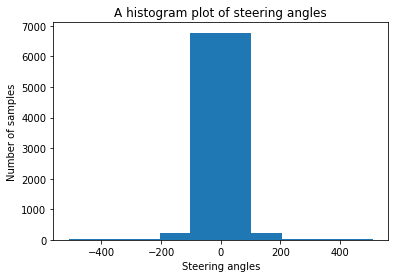

In [14]:
plt.hist(steering_angles)
plt.xlabel('Steering angles')
plt.ylabel('Number of samples')
plt.title('A histogram plot of steering angles')
plt.show()

### Split the images into 80% train data and 20% test data

In [0]:
split = int (len(camera_images) * 0.8)

X_train = camera_images[:split]
Y_train = steering_angles[:split]

X_test = camera_images[split:]
Y_test = steering_angles[split:]

In [0]:
del(camera_images)
del(steering_angles)

### Normalizing the steering angles and camera images before feeding into the neural network

In [0]:
X_train = (X_train/255.0) - 0.5
X_test = (X_test/255.0) - 0.5

MAX_STEER = np.max(Y_train)
MIN_STEER = np.min(Y_train)

Y_train = [((y - MIN_STEER) / (MAX_STEER - MIN_STEER) -0.5) for y in Y_train]
Y_test = [((y - MIN_STEER) / (MAX_STEER - MIN_STEER) - 0.5) for y in Y_test]

(array([  27.,   11.,   15.,  169., 5415., 5427.,  172.,   21.,    7.,
          27.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

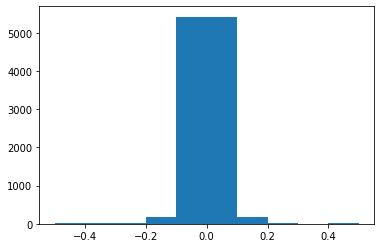

In [18]:
plt.hist(Y_train)

### Building the Network architecture

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(16, (9,9), strides=(4,4), activation='relu', input_shape=(160,320,4), 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    #tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (5,5), strides=(2,2), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),   # This layer is used to flatten the input data matrix
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
   
    tf.keras.layers.Dense(1)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss = 'mean_squared_error', 
              optimizer = opt,
              metrics = ['mae']  
              )

### Training the model

In [21]:
history = model.fit(X_train, Y_train, epochs = 80, batch_size=128, validation_data = (X_test, Y_test), shuffle = True)

Train on 11291 samples, validate on 2823 samples
Epoch 1/80
11291/11291 [==============================] - 20s 2ms/sample - loss: 0.0042 - mean_absolute_error: 0.0298 - val_loss: 0.0026 - val_mean_absolute_error: 0.0244
Epoch 2/80
11291/11291 [==============================] - 20s 2ms/sample - loss: 0.0026 - mean_absolute_error: 0.0244 - val_loss: 0.0025 - val_mean_absolute_error: 0.0230
Epoch 3/80
11291/11291 [==============================] - 20s 2ms/sample - loss: 0.0024 - mean_absolute_error: 0.0247 - val_loss: 0.0024 - val_mean_absolute_error: 0.0243
Epoch 4/80
11291/11291 [==============================] - 20s 2ms/sample - loss: 0.0023 - mean_absolute_error: 0.0249 - val_loss: 0.0022 - val_mean_absolute_error: 0.0216
Epoch 5/80
11291/11291 [==============================] - 20s 2ms/sample - loss: 0.0019 - mean_absolute_error: 0.0229 - val_loss: 0.0017 - val_mean_absolute_error: 0.0216
Epoch 6/80
11291/11291 [==============================] - 20s 2ms/sample - loss: 0.0016 - mean_a

### Interpreting the training and validation **loss** across various epochs

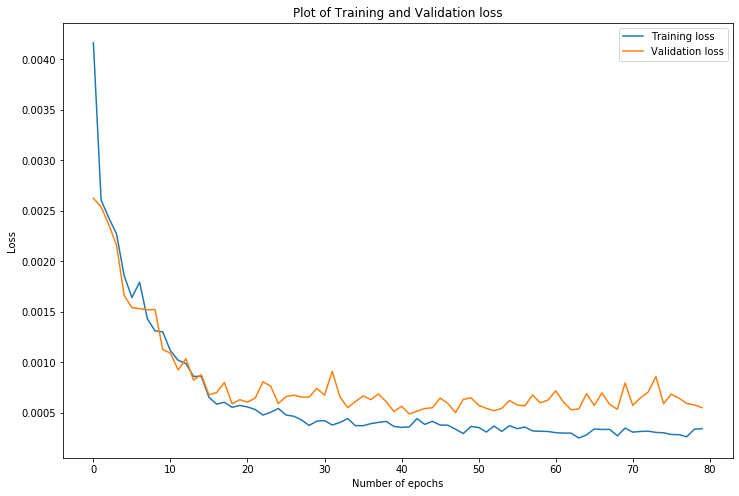

In [22]:
plt.rcParams["figure.figsize"] = [12,8]
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Plot of Training and Validation loss')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

### Interpreting the **Mean absolute error** for training validations during training

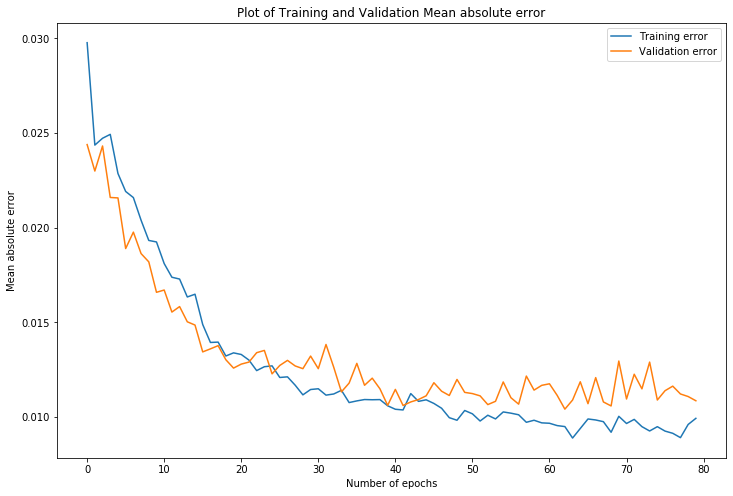

In [23]:
plt.rcParams["figure.figsize"] = [12,8]
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.xlabel('Number of epochs')
plt.ylabel('Mean absolute error')
plt.title('Plot of Training and Validation Mean absolute error')
plt.legend(['Training error', 'Validation error'])
plt.show()

### Save the weights containing the learned parameters

In [0]:
model.save_weights(r'/content/drive/My Drive/new_beamng_data_collection/savedWeights/weight.json')

### Prediction of steering angles for the test set

In [0]:
predictions = model.predict(X_test)

In [51]:
predictions

array([[0.00035011],
       [0.00505422],
       [0.06962562],
       ...,
       [0.02678803],
       [0.00093377],
       [0.00384641]], dtype=float32)

### Plot of the steering angles

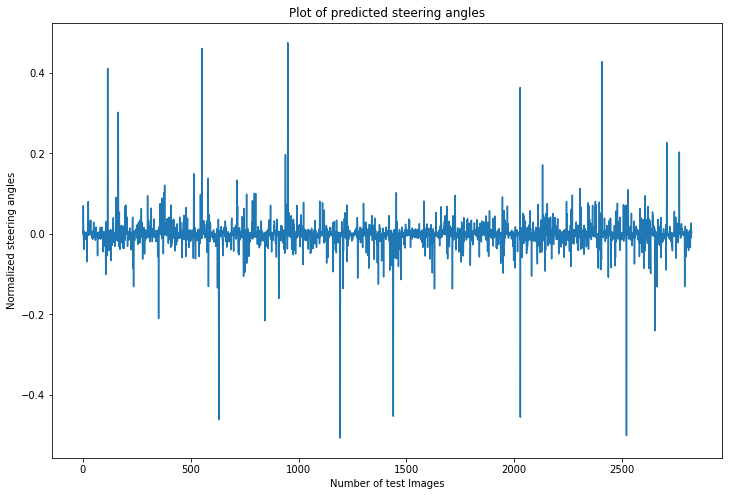

In [26]:
plt.rcParams["figure.figsize"] = [12,8]
plt.plot(predictions)
plt.xlabel('Number of test Images')
plt.ylabel('Normalized steering angles')
plt.title('Plot of predicted steering angles')
plt.show()

### Plot of the actual steering angles

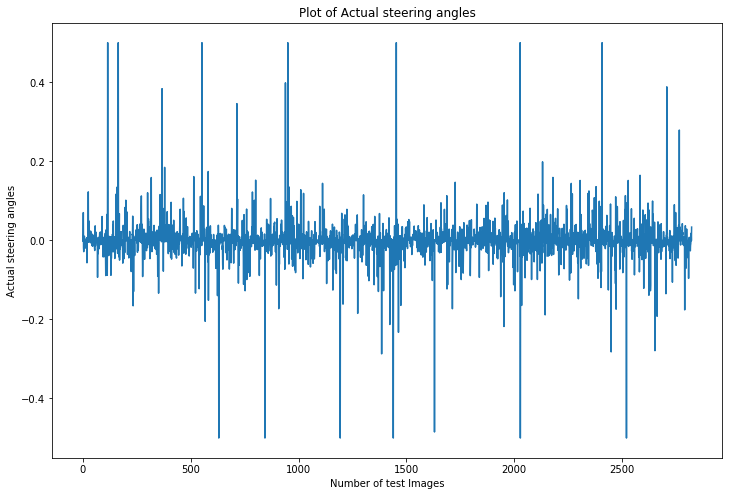

In [27]:
plt.rcParams["figure.figsize"] = [12,8]
plt.plot(Y_test)
plt.xlabel('Number of test Images')
plt.ylabel('Actual steering angles')
plt.title('Plot of Actual steering angles')
plt.show()

### The predicted and actual steering angles overlap for most of the samples, indicating more similarity between the predicted and actual steering angles

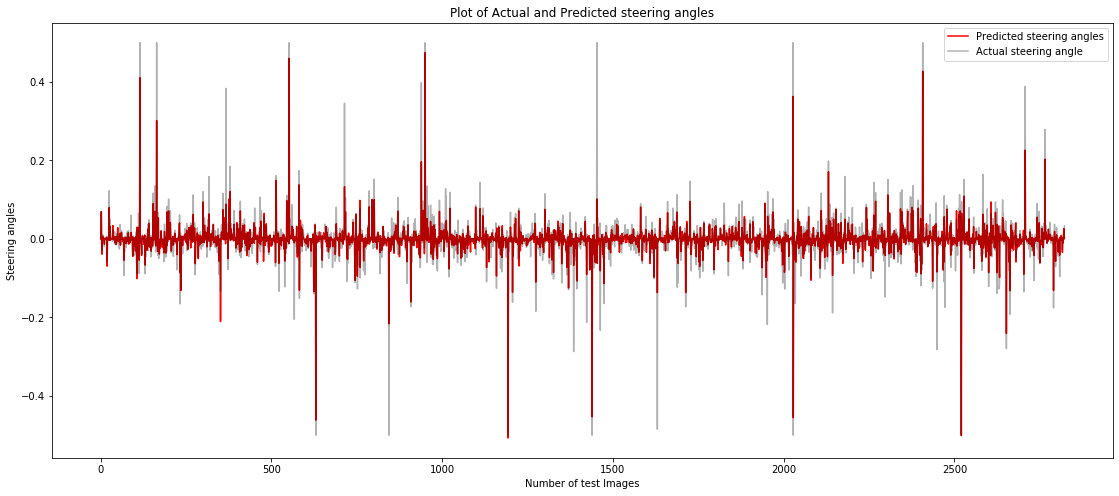

In [42]:
plt.rcParams["figure.figsize"] = [19,8]
plt.plot(predictions, color="red")
plt.plot(Y_test, alpha = 0.30, color="black")
plt.xlabel('Number of test Images')
plt.ylabel('Steering angles')
plt.title('Plot of Actual and Predicted steering angles')
plt.legend(['Predicted steering angles','Actual steering angle'])
plt.show()